<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Testing different Hyperparameters and Benchmarking

In this notebook, we'll cover how to test different hyperparameters for a particular dataset and how to benchmark different parameters across a group of datasets.

For an example of how to scale up with remote GPU clusters on Azure Machine Learning, please view [24_exploring_hyperparameters_on_azureml.ipynb](../24_exploring_hyperparameters_on_azureml).
## Table of Contents

* [Testing hyperparameters](#hyperparam)
  * [Using Python](#python)
  * [Using the CLI](#cli)
  * [Visualizing the results](#visualize)

---

## Testing hyperparameters  <a name="hyperparam"></a>

Let's say we want to learn more about __how different learning rates and different image sizes affect our model's accuracy when restricted to 10 epochs__, and we want to build an experiment to test out these hyperparameters. We also want to try these parameters out on two different variations of the dataset - one where the images are kept raw (maybe there is a watermark on the image) and one where the images have been altered (the same dataset where there was some attempt to remove the watermark).

In this notebook, we'll walk through how we use the Parameter Sweeper module with the following:

- use python to perform this experiment
- use the CLI to perform this experiment
- evalute the results using Pandas

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We start by importing the utilities we need.

In [12]:
import sys
import numpy as np
import scrapbook as sb
import fastai
from fastai.vision import DatasetType

sys.path.append("../../")
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.classification.parameter_sweeper import ParameterSweeper, clean_sweeper_df, plot_sweeper_df
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import positive_image_ranks
from utils_cv.similarity.model import compute_features_learner

fastai.__version__

'1.0.48'

To use the Parameter Sweeper tool for single label classification, we'll need to make sure that the data is stored such that images are sorted into their classes inside of a subfolder. In this notebook, we'll use the Fridge Objects dataset, which is already stored in the correct format. We also want to use the Fridge Objects Watermarked dataset. We want to see whether the original images (which are watermarked) will perform just as well as the non-watermarked images.

Define some parameters we will use in this notebook

In [13]:
#from urlparse import urljoin
base = "https://cvbp.blob.core.windows.net/public/datasets/image_classification/"
food_101_subset_path = os.path.join(base, "food101Subset.zip")
fashion_texture_path = os.path.join(base, "fashionTexture.zip")
flickr_logos_32_subset_path = os.path.join(base, "flickrLogos32Subset.zip")
lettuce_path = os.path.join(base, "lettuce.zip")
recycle_path = os.path.join(base, "recycle_v3.zip")
# DATA = [unzip_url(Urls.fridge_objects_path, exist_ok=True),
#         unzip_url(lettuce_path, exist_ok=True),
#         unzip_url(recycle_path, exist_ok=True),
#         unzip_url(fashion_texture_path, exist_ok=True),
#         unzip_url(flickr_logos_32_subset_path, exist_ok=True),
#         unzip_url(food_101_subset_path, exist_ok=True)]

DATA = [unzip_url(Urls.fridge_objects_tiny_path, exist_ok=True)]
REPS = 1 #3
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
IM_SIZES = [299, 499]
EPOCHS = [0] # [10]

### Similiarity accuracy metric

We below define how to measure accuracy of our image retrieval system. Note that this is identical to the code in the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook.

In [14]:
def similarity_accuracy(learn):
    data = learn.data

    # Build multiple sets of comparative images from the validation images
    comparative_sets = comparative_set_builder(
        data.valid_ds, num_sets=1000, num_negatives=99
    )

    # Compute DNN features for all validation images
    embedding_layer = learn.model[1][6]
    valid_features = compute_features_learner(
        data, DatasetType.Valid, learn, embedding_layer
    )

    # For each comparative set compute the distances between the query image and all reference images
    for cs in comparative_sets:
        cs.compute_distances(valid_features)

    # Compute the median rank of the positive example over all comparative sets
    ranks = positive_image_ranks(comparative_sets)
    median_rank = np.median(ranks)
    return median_rank

### Using Python <a name="python"></a>

We start by creating the Parameter Sweeper object:

In [15]:
sweeper = ParameterSweeper()

Before we start testing, it's a good idea to see what the default parameters are. We can use a the property `parameters` to easily see those default values.

In [16]:
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x00000163A028DAE8>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True])])

Now that we know the defaults, we can pass it the parameters we want to test. 

In this notebook, we want to see the effect of different learning rates across different image sizes using only 10 epochs (the default number of epochs is 15). To do so, I would run the `update_parameters` functions as follows:

```python
sweeper.update_parameters(learning_rate=[1e-3, 1e-4, 1e-5], im_size=[299, 499], epochs=[10])
```

Notice that all parameters must be passed in as a list, including single values such the number of epochs.

These parameters will be used to calculate the number of permutations to run. In this case, we've pass in three options for learning rates, two for image sizes, and one for number of epochs. This will result in 3 X 2 X 1 total permutations (in otherwords, 6 permutations). 

In [17]:
sweeper.update_parameters(learning_rate=LEARNING_RATES, im_size=IM_SIZES, epochs=EPOCHS)

Now that we have our parameters defined, we call the `run()` function with the dataset to test on. We can also optionally pass in:
- the number of repetitions to run each permutation (default is 3)
- whether or not we want the training to stop early if the metric (accuracy) doesn't improve by 0.01 (1%) over 3 epochs (default is False)

The `run` function returns a multi-index dataframe which we can work with right away.

In [18]:
df = sweeper.run(datasets=DATA, reps=REPS, accuracy_hook=similarity_accuracy); df

this Learner object self-destroyed - it still exists, but no longer usable


duration  \
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 0]|... fridgeObjectsTiny  2.199737   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 0]|... fridgeObjectsTiny  3.509203   
  PARAMETERS [learning_rate: 0.001]|[epochs: 0]|[... fridgeObjectsTiny  5.701824   
  PARAMETERS [learning_rate: 0.001]|[epochs: 0]|[... fridgeObjectsTiny  3.551486   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 0]|[... fridgeObjectsTiny  2.116648   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 0]|[... fridgeObjectsTiny  3.723362   

                                                                        accuracy  
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 0]|... fridgeObjectsTiny      14.0  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 0]|... fridgeObjectsTiny      15.0  
  PARAMETERS [learning_rate: 0.001]|[epochs: 0]|[... fridgeObjectsTiny      19.0  
  PARAMETERS [learning_rate: 0.001]|[epochs: 0]|[... fridgeObjectsTiny      26.0  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 0]|[... fridgeObjectsTiny      14.0  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 0]|[... fridgeObjectsTiny      28.0

### Using the CLI <a name="cli"></a>

Instead of using python to run this experiment, we may want to test from the CLI. We can do so by using the `scripts/sweep.py` file. 

To reproduce the same test (different learning rates across different image sizes using only 10 epochs), and the same settings (3 repetitions, and no early_stopping) we can run the following:

```sh
python scripts/sweep.py 
    --learning-rates 1e-3 1e-4 1e-5
    --im-size 99 299
    --epochs 10 
    --repeat 3 
    --no-early-stopping 
    --inputs <my-data-dir>
    --output lr_bs_test.csv
```

Additionally, we've added an output parameter, which will automatically dump our dataframe into a csv file. To simplify the command, we can use the acryonyms of the params. We can also remove `--no-early-stopping` as that is the default behavior.

```sh
python scripts/sweep.py -lr 1e-3 1e-4 1e-5 -is 99 299 -e 10 -i <my-data-dir> -o lr_bs_test.csv
```

Once the script completes, load the csv into a dataframe to explore it's contents. We'll want to specify `index_col=[0, 1, 2]` since it is a multi-index dataframe.

```python
df = pd.read_csv("data/lr_bs_test.csv", index_col=[0, 1, 2])
```

HINT: You can learn more about how to use the script with the `--help` flag.

```python
python scripts/sweep.py --help
```

### Visualize Results <a name="visualize"></a>

When we read in multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset.

To see the results, show the df using the `clean_sweeper_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [19]:
df = clean_sweeper_df(df)

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [20]:
df.mean(level=(1,2)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
,fridgeObjectsTiny,fridgeObjectsTiny,fridgeObjectsTiny,fridgeObjectsTiny,fridgeObjectsTiny,fridgeObjectsTiny
duration,2.199737,3.509203,5.701824,3.551486,2.116648,3.723362
accuracy,14.000000,15.000000,19.000000,26.000000,14.000000,28.000000


Print the average accuracy over the different runs for each dataset independently.

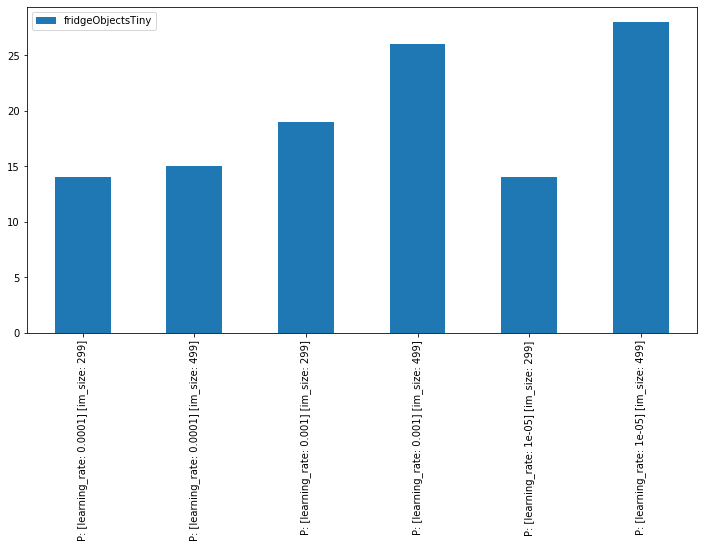

In [29]:
ax = df.mean(level=(1,2))["accuracy"].unstack().plot(kind='bar', figsize=(12, 6))
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])

Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets.

In [22]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
duration,2.199737,3.509203,5.701824,3.551486,2.116648,3.723362
accuracy,14.000000,15.000000,19.000000,26.000000,14.000000,28.000000


To make it easier to see which permutation did the best, we can plot the results using the `plot_sweeper_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

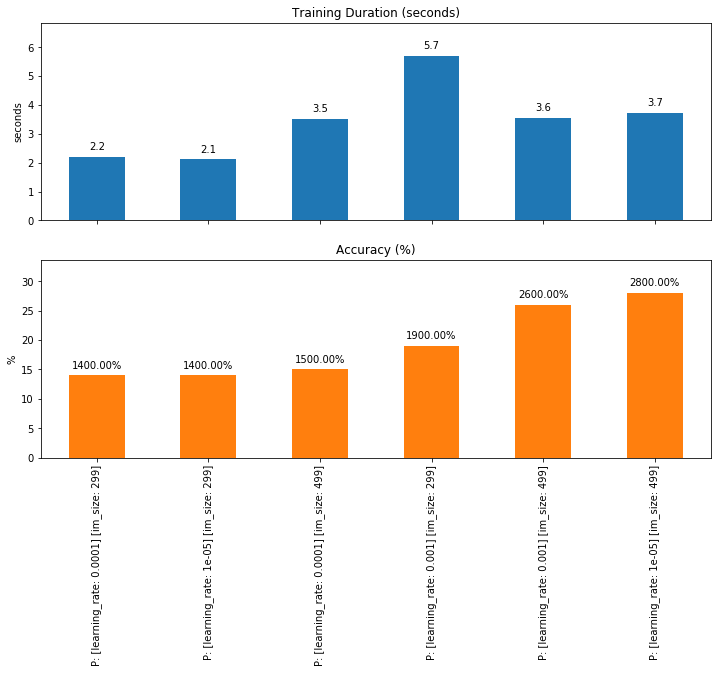

In [23]:
plot_sweeper_df(df.mean(level=(1)), sort_by="accuracy")

In [24]:
# Preserve some of the notebook outputs
sb.glue("nr_elements", len(df))
sb.glue("max_accuray", df.max().accuracy)
sb.glue("min_accuray", df.min().accuracy)
sb.glue("max_duration", df.max().duration)
sb.glue("min_duration", df.min().duration)

AttributeError: module 'scrapbook' has no attribute 'glue'